In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


In [45]:
#df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data_Population_Normalized.csv")
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

In [46]:
print(df.columns)
print(df.shape)

Index(['week_no', 'iso_code', 'new_cases', 'new_deaths', 'new_vaccinations',
       'new_people_vaccinated', 'reproduction_rate', 'stringency_index',
       'excess_mortality', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population'],
      dtype='object')
(41184, 21)


In [47]:

df.drop(["iso_code", "week_no"], axis=1, inplace=True)
#df.drop(columns=df.columns[0:1], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41183, dtype: float64


In [48]:
# now we want to join datas together
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

for i in range(234):  # 234 is number of countries
    for j in range(176):  # 176 is number of weeks we have
        row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
        features_list.append(row_list)

for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


In [49]:
print(len(X_list))
print(len(Y_list))
np.shape(X_list)

40950
40950


(40950, 38)

In [50]:
# Here we are going to normalize the data.
from sklearn import preprocessing
x_df = pd.DataFrame(X_list)
min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

#df = pd.DataFrame(x_scaled)

In [51]:
import math

def train_test_splitter(X, Y, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / 234)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
    i = 0
    for i in range(234):
        j = 0
        for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
    return X_train, X_test, Y_train, Y_test
        

In [52]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list, prediction_days_count, 3, 10)


In [72]:
X_train, X_val, y_train, y_val = train_test_splitter(X_train, Y_train, prediction_days_count, 3, 10)


In [73]:
print("X_train:", np.shape(X_train),
      ",X_val:" , np.shape(X_val),
      ",X_test:", np.shape(X_test),

      ",Y_train:" ,np.shape(Y_train),
      ",Y_val:", np.shape(y_val),
      ",Y_test:", np.shape(Y_test)
      )

X_train: (33930, 38) ,X_val: (1404, 38) ,X_test: (1404, 38) ,Y_train: (36270, 1) ,Y_val: (1404, 1) ,Y_test: (1404, 1)


In [69]:
type(X_val)

list

In [54]:
X_tr = np.array(X_train)
y_tr = np.array(Y_train)
X_te = np.array(X_test)
y_te = np.array(Y_test)
X_val = np.array(X_val)
X_val = np.array(y)

In [55]:
# Rescale predictions and true values back to original scale
def rescale_data(scaler, data):
    return scaler.inverse_transform(np.array(data).reshape(-1, 1)).flatten()

# Modelling

## Importing loss functions

In [56]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, d2_tweedie_score


## Model Evaluation

In [57]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name):
    y_pred_scaled = model.fit(X_train, y_train).predict(X_test)
    y_pred = rescale_data(scaler, y_pred_scaled)
    y_test_rescaled = rescale_data(scaler, y_test)

    mae = mean_absolute_error(y_test_rescaled, y_pred)
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred)
    rmse = mean_squared_error(y_test_rescaled, y_pred, squared=False)

    print(f"Evaluating {model_name}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"RMSE: {rmse}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted')
    plt.plot(np.arange(len(y_pred)), y_test_rescaled, alpha=0.6, label='True')
    plt.title(f"{model_name} Predictions vs True Values")
    plt.legend()
    plt.show()

## SVR

In [58]:
from sklearn.svm import SVR

C:\Users\hafez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating SVR (rbf)
MAE: 19866.522835365413
MAPE: 2.0782567017633812e+19
RMSE: 24672.632090517098



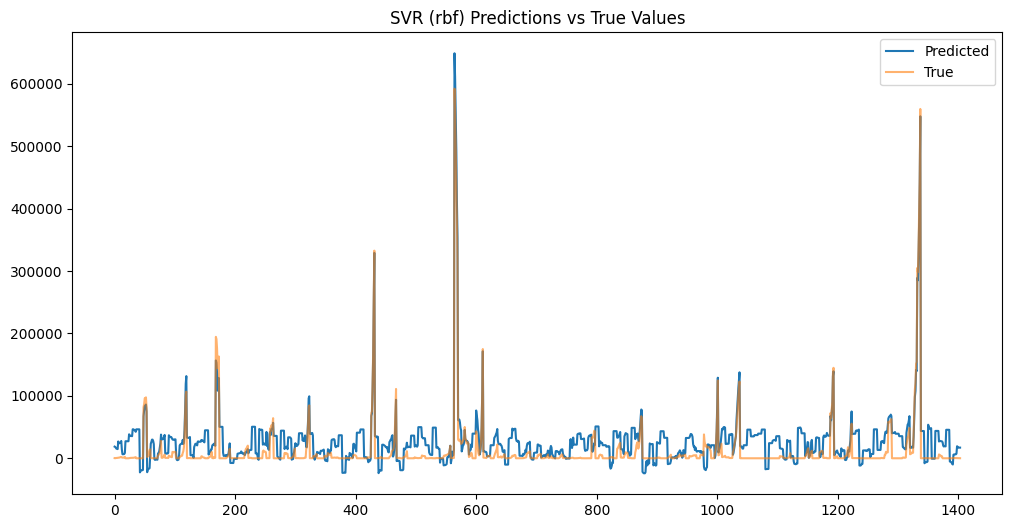

C:\Users\hafez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating SVR (linear)
MAE: 3652484.08032749
MAPE: 2.6074395698846604e+21
RMSE: 3658351.2986804293



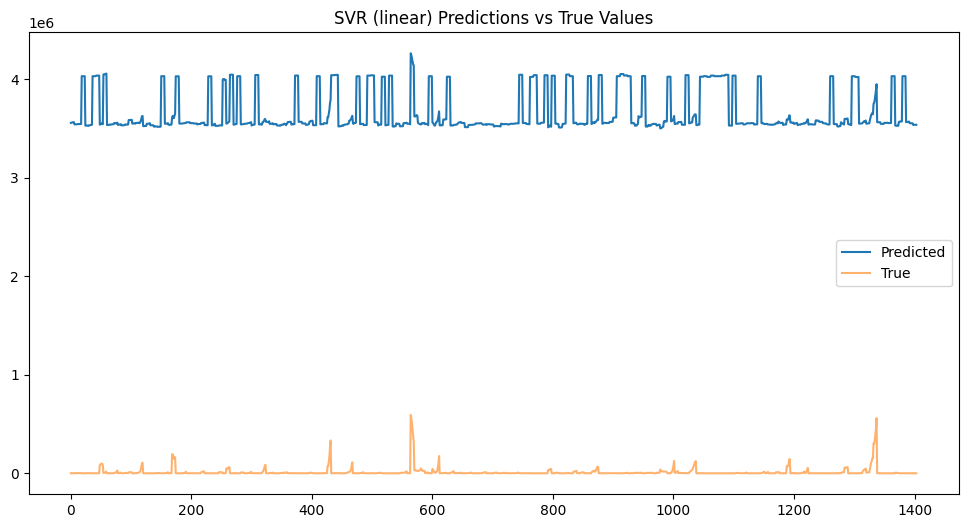

C:\Users\hafez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating SVR (poly)
MAE: 3739877.1108789514
MAPE: 2.64257215494668e+21
RMSE: 3743996.195399085



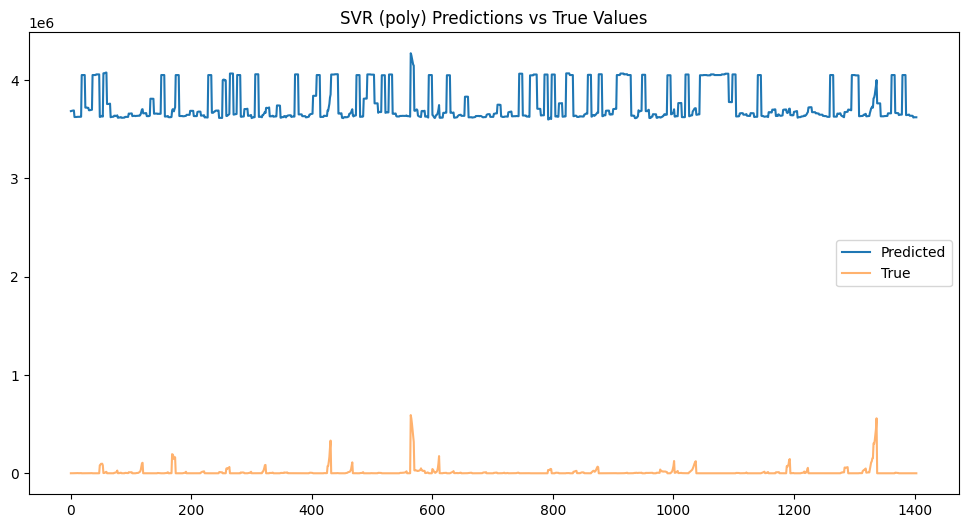

In [64]:
# Train and evaluate SVR models
svrs = [SVR(kernel="rbf", C=50, gamma=0.9, epsilon=0.001),
        SVR(kernel="linear", C=100, gamma="auto"),
        SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)]

for svr in svrs:
    evaluate_model(svr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name=f"SVR ({svr.kernel})")


## KNN

In [17]:
from sklearn.neighbors import KNeighborsRegressor

Evaluating KNeighborsRegressor
MAE: 4774.005698005698
MAPE: 1.0242481460225594e+17
RMSE: 16504.53522111509



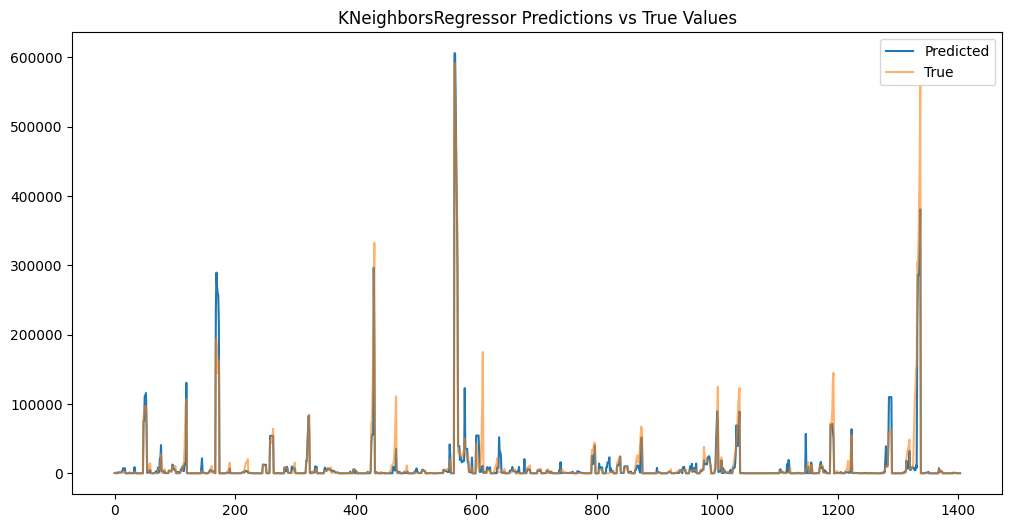

In [18]:
# Train and evaluate KNeighborsRegressor model
neigh = KNeighborsRegressor(n_neighbors=2, p=2)
evaluate_model(neigh, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="KNeighborsRegressor")


## Polynomial

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR

/home/kia/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating Polynomial Regression
MAE: 1084.852630185176
MAPE: 5.5812041490307424e+17
RMSE: 1524.4618969266028



/home/kia/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


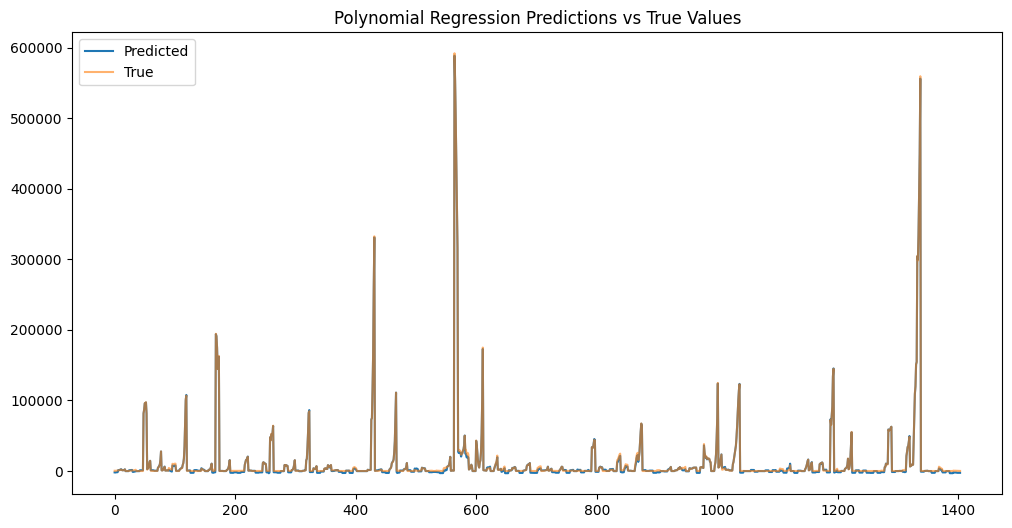

In [20]:
poly = PolynomialFeatures(degree=2)
X_poly_tr = poly.fit_transform(X_tr)
X_poly_te = poly.transform(X_te)

linear_model = LinearSVR(dual="auto", random_state=42)
evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_te, y_te, min_max_scaler_Y, model_name="Polynomial Regression")

## AdaBoost

In [21]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

/home/kia/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating AdaBoostRegressor
MAE: 21510.340253581624
MAPE: 1.366848060678793e+19
RMSE: 28550.479932368402



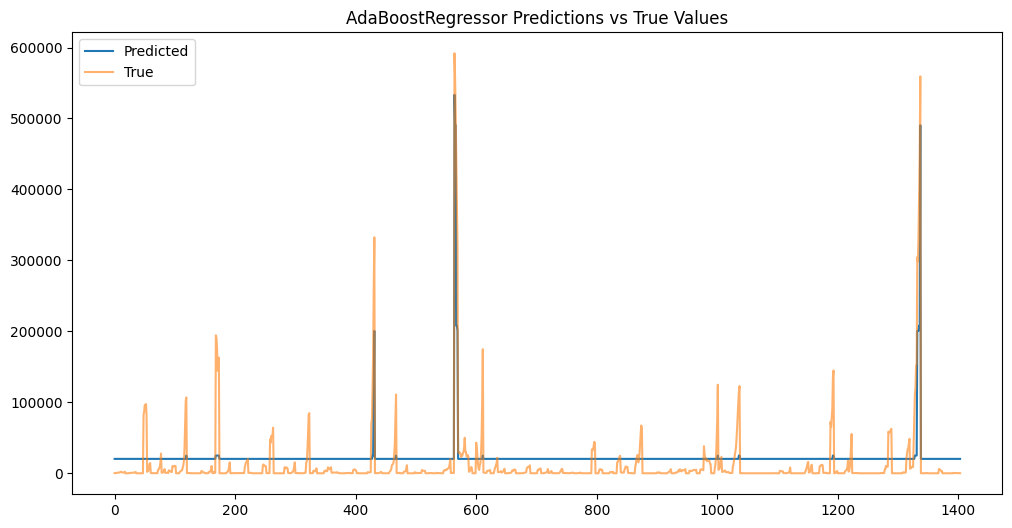

In [22]:
# Train and evaluate AdaBoostRegressor model
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="AdaBoostRegressor")

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

/home/kia/.local/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Evaluating RandomForestRegressor
MAE: 4164.832738936622
MAPE: 1.9638171201587607e+18
RMSE: 6513.898202521465



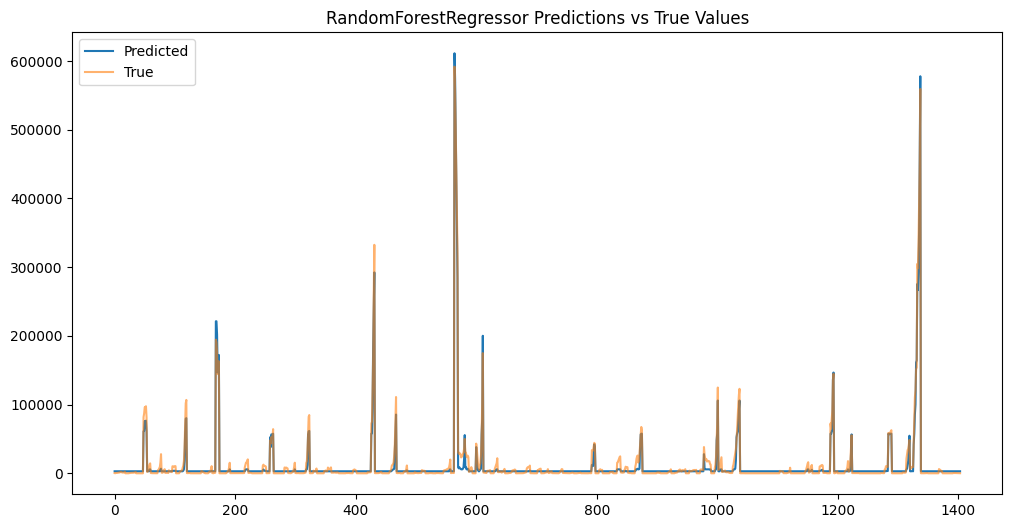

In [24]:
# Train and evaluate RandomForestRegressor model
regr = RandomForestRegressor(max_depth=4, random_state=0)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="RandomForestRegressor")

## Stacking

In [25]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

/home/kia/.local/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kia/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/kia/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluating StackingRegressor
MAE: 187.28915119154928
MAPE: 9.080989287489277e+16
RMSE: 489.40765259108707



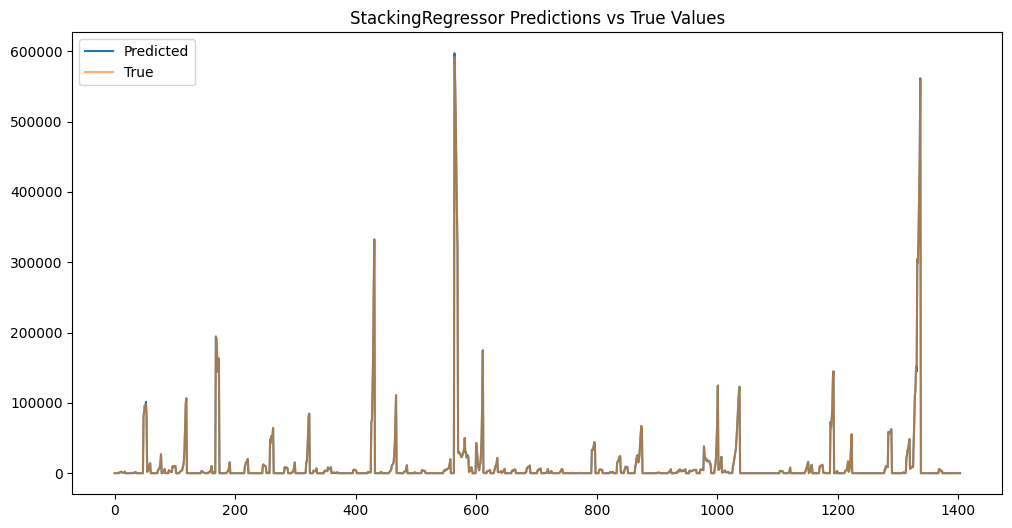

In [26]:
# Train and evaluate StackingRegressor model
estimators = [('lr', RidgeCV()), ('svr', LinearSVR(dual="auto", random_state=42))]
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))
evaluate_model(reg, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="StackingRegressor")

In [30]:
#check to see if my rescaling is working as intended

# Test scaling and rescaling
sample_y = [y_scaled[0], y_scaled[10], y_scaled[100]]
print("Sample scaled values:", sample_y)

rescaled_y = rescale_data(min_max_scaler_Y, sample_y)
print("Rescaled values:", rescaled_y)

original_y = [Y_list[0], Y_list[10], Y_list[100]]
print("Original values:", original_y)

# Check if rescaled values match the original values
print("Match:", np.allclose(rescaled_y, original_y))

Sample scaled values: [array([0.]), array([4.20007403e-07]), array([4.44713721e-06])]
Rescaled values: [  0.  17. 180.]
Original values: [0.0, 17.0, 180.0]
Match: True


# TEST

In [27]:
# ns_list, train_scores, validation_scores = learning_curve(
#                                                    estimator = SVR(**opt_svr_param), 
#                                                    X = X, y = Y, 
#                                                    train_sizes = ns_list, cv = 5,
#                                                    scoring = 'neg_mean_squared_error')


In [28]:
# train_scores, valid_scores = validation_curve(KNeighborsRegressor(), X, Y, 
#                                               param_name="n_neighbors",
#                                               param_range=k_list , cv=20, 
#                                               scoring = 'neg_mean_squared_error',
#                                               verbose=1, n_jobs=-1
#                                              )
